This notebook demonstrates most of the functionality offered by the robpy package through an application to the TopGear dataset. Utility functions and univariate estimators are not demonstrated separately, as they are mostly implemented as helpers to the multivariate estimators.

# Imports

In [1]:

import json
import matplotlib.pyplot as plt
import numpy as np

from robpy.datasets import load_topgear
from robpy.preprocessing import DataCleaner, RobustPowerTransformer, RobustScaler
from robpy.covariance import FastMCDEstimator, OGKEstimator
from robpy.pca import ROBPCAEstimator
from robpy.outliers import DDCEstimator
from robpy.regression import MMEstimator

%load_ext autoreload
%autoreload 2


# Load data

Robpy has a dataset module which allows the user quick access to a few common datasets used in robust statistics literature. In this demo, we will work with the TopGear dataset.

In [2]:
data = load_topgear(as_frame=True)

print(data.DESCR)

.. _topgear_dataset:

TopGear dataset
--------------------

**Data Set Characteristics:**

- Number of Instances: 297 
- Number of Attributes: 32 (13 numeric, 19 categorical)
- Attribute Information:
    * Maker (str): the car maker.
    * Model (str): the car model.
    * Type (str): the exact model type.
    * Fuel (str): the type of fuel ("Diesel" or "Petrol").
    * Price (float): the list price (in UK pounds)
    * Cylinders (float): the number of cylinders in the engine.
    * Displacement (float): the displacement of the engine (in cc).
    * DriveWheel (str): the type of drive wheel ("4WD", "Front" or "Rear").
    * BHP (float): the power of the engine (in bhp).
    * Torque (float): the torque of the engine (in lb/ft).
    * Acceleration (float): the time it takes the car to get from 0 to 62 mph (in seconds).
    * TopSpeed (float): the car's top speed (in mph).
    * MPG (float): the combined fuel consuption (urban + extra urban; in miles per gallon).
    * Weight (float): th

The `DESCR` attribute of the data object contains all metadata and a description of the dataset.

In [3]:
data.data.head()

,Maker,Model,Type,Fuel,Price,Cylinders,Displacement,DriveWheel,BHP,Torque,...,ClimateControl,CruiseControl,ElectricSeats,Leather,ParkingSensors,PowerSteering,SatNav,ESP,Verdict,Origin
0,Alfa Romeo,Giulietta,Giulietta 1.6 JTDM-2 105 Veloce 5d,Diesel,21250.0,4.0,1598.0,Front,105.0,236.0,...,standard,standard,optional,optional,optional,standard,optional,standard,6.0,Europe
1,Alfa Romeo,MiTo,MiTo 1.4 TB MultiAir 105 Distinctive 3d,Petrol,15155.0,4.0,1368.0,Front,105.0,95.0,...,optional,standard,no,optional,standard,standard,optional,standard,5.0,Europe
2,Aston Martin,Cygnet,Cygnet 1.33 Standard 3d,Petrol,30995.0,4.0,1329.0,Front,98.0,92.0,...,standard,standard,no,no,no,standard,standard,standard,7.0,Europe
3,Aston Martin,DB9,DB9 6.0 517 Standard 2d 13MY,Petrol,131995.0,12.0,5935.0,Rear,517.0,457.0,...,standard,standard,standard,standard,standard,standard,standard,standard,7.0,Europe
4,Aston Martin,DB9 Volante,DB9 6.0 V12 517 Volante 2d 13MY,Petrol,141995.0,12.0,5935.0,Rear,517.0,457.0,...,standard,standard,standard,standard,standard,standard,standard,standard,7.0,Europe


# Preprocess data

## Cleaning

We use `DataCleaner` to remove non-numeric columns, as well as columns and rows with too many missing values, discrete columns, columns with a scale of zero and columns corresponding to the case numbers.

In [4]:
cleaner = DataCleaner().fit(data.data)
clean_data = cleaner.transform(data.data)

We can inspect the dropped columns by type:

In [5]:
print(json.dumps(cleaner.dropped_columns, indent=4))

{
    "non_numeric_cols": [
        "Maker",
        "Model",
        "Type",
        "Fuel",
        "DriveWheel",
        "AdaptiveHeadlights",
        "AdjustableSteering",
        "AlarmSystem",
        "Automatic",
        "Bluetooth",
        "ClimateControl",
        "CruiseControl",
        "ElectricSeats",
        "Leather",
        "ParkingSensors",
        "PowerSteering",
        "SatNav",
        "ESP",
        "Origin"
    ],
    "cols_rownumbers": [],
    "cols_discrete": [
        "Fuel",
        "DriveWheel",
        "AdaptiveHeadlights",
        "AdjustableSteering",
        "AlarmSystem",
        "Automatic",
        "Bluetooth",
        "ClimateControl",
        "CruiseControl",
        "ElectricSeats",
        "Leather",
        "ParkingSensors",
        "PowerSteering",
        "SatNav",
        "ESP",
        "Origin"
    ],
    "cols_bad_scale": [
        "Cylinders"
    ],
    "cols_missings": []
}


As well as the dropped rows:

In [6]:
cleaner.dropped_rows

{'rows_missings': [69, 95]}

Let's also exclude the variable `Verdict` from the features for further analysis.

In [7]:
clean_data = clean_data.drop(columns=['Verdict'])

## Transforming

The `Price` variable has a long tail. It's a good idea to apply a power transformation to it to make it more symmetric.

<Axes: >

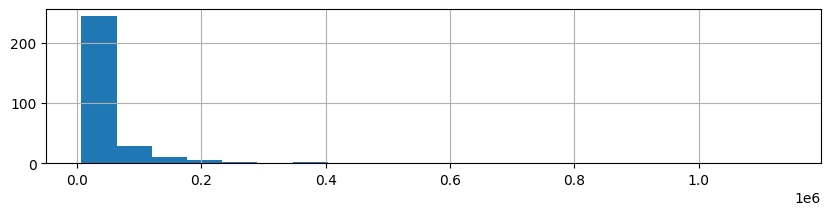

In [8]:
clean_data['Price'].hist(bins=20, figsize=(10, 2))

In [9]:
price_transformer = RobustPowerTransformer(method='auto').fit(clean_data['Price'])

clean_data['Price_transformed'] = price_transformer.transform(clean_data['Price'])

We can inspect which method was selected as well as which lambda value was applied for the transformation:

In [10]:
price_transformer.method, price_transformer.lambda_rew

('boxcox', -0.42354039562300644)

<Axes: >

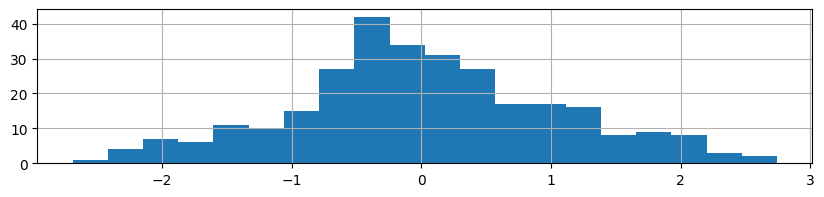

In [11]:
clean_data['Price_transformed'].hist(bins=20, figsize=(10, 2))

It's best to also transform `displacement`, `HP`, `Torque` and `Topspeed` as these variables are also skewed.

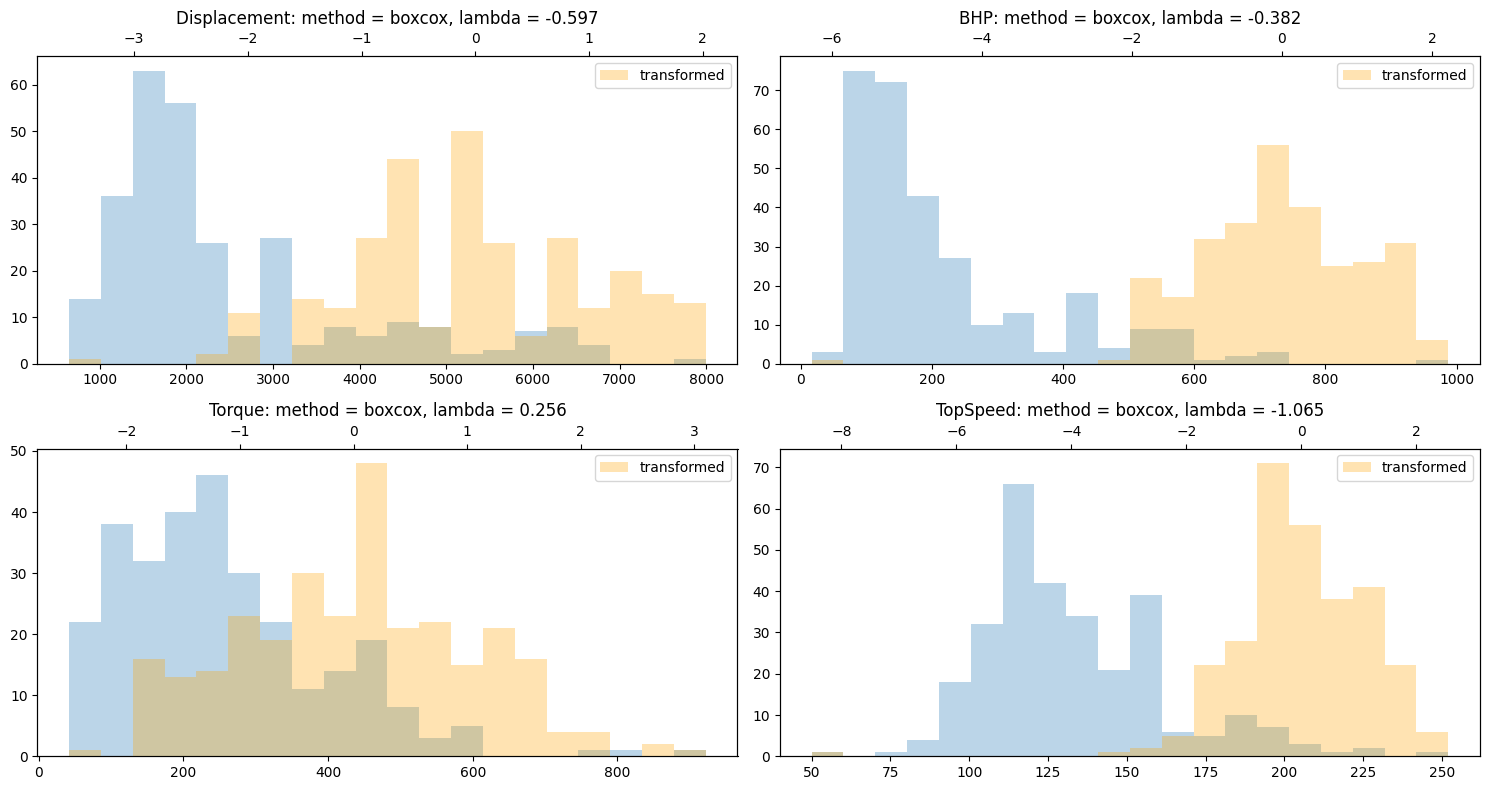

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
for col, ax in zip(['Displacement', 'BHP', 'Torque', 'TopSpeed'], axs.flatten()):
    clean_data[col].hist(ax=ax, bins=20, alpha=0.3)
    transformer = RobustPowerTransformer(method='auto').fit(clean_data[col].dropna())
    clean_data.loc[~np.isnan(clean_data[col]), col] = transformer.transform(clean_data[col].dropna())
    ax2=ax.twiny()
    clean_data[col].hist(ax=ax2, bins=20, label='transformed', color='orange', alpha=0.3)
    ax.grid(False)
    ax2.grid(False)
    ax2.legend(loc='upper right')
    ax.set_title(f'{col}: method = {transformer.method}, lambda = {transformer.lambda_rew:.3f}')
fig.tight_layout()

## Dropping NA

Some methods require the data to be entirely NA free.

In [13]:
clean_data2 = clean_data.dropna()

# Covariance

First we study the covariance of the dataset by calculating a robust covariance matrix on the numeric features.

## MCD: Minimum Covariance Determinant

In [14]:
mcd = FastMCDEstimator().fit(clean_data2.drop(columns=['Price']))

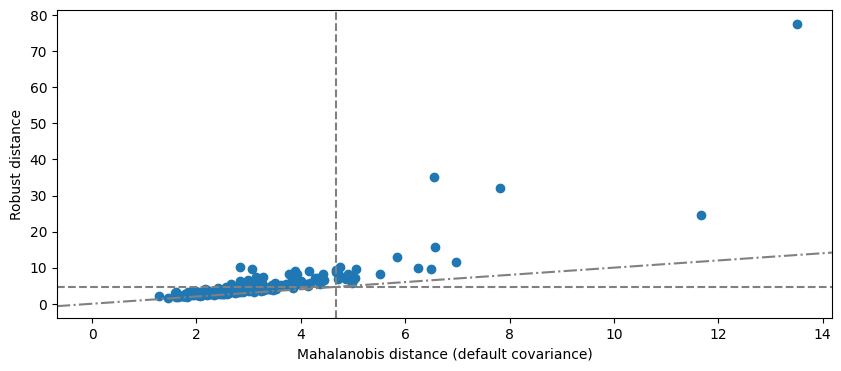

In [15]:
fig = mcd.distance_distance_plot()

## OGK: Orthogonalized Gnanadesikan-Kettenring covariance

We can do the same analysis with other robust covariance estimators, e.g. the OGK covariance:

In [16]:
ogk = OGKEstimator().fit(clean_data2.drop(columns=['Price']))

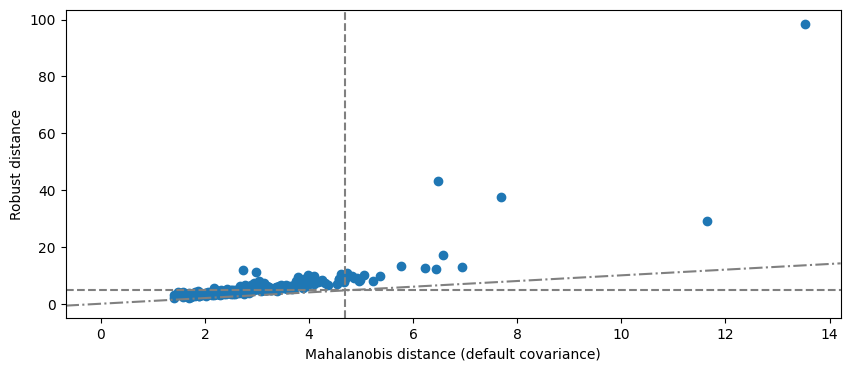

In [17]:
fig = ogk.distance_distance_plot()

Let's have a look at the point that seems to lie very far from the majority of the data:

In [18]:
data.data.loc[
    clean_data2.index[(ogk._robust_distances > 80) & (ogk._mahalanobis_distances > 12)], 
    ['Maker', 'Model'] + list(set(clean_data2.columns).intersection(set(data.data.columns)))
]

,Maker,Model,Displacement,TopSpeed,Torque,Weight,Price,Length,Width,Acceleration,Height,BHP,MPG
41,BMW,i3,647.0,93.0,184.0,1315.0,33830.0,3999.0,1775.0,7.9,1578.0,170.0,470.0


## CellMCD

Another robust covariance estimator that can handle missing values is the CellMCD. For more details, we refer to the separate notebook on this topic.

# PCA

Next, we apply a well-known robust PCA method to the data, specifically ROBPCA. As the variables of interest have different measurement units and different scales, we first scale the data.

In [19]:
scaled_data = RobustScaler(with_centering=False).fit_transform(clean_data2.drop(columns=['Price']))
pca = ROBPCAEstimator().fit(scaled_data)

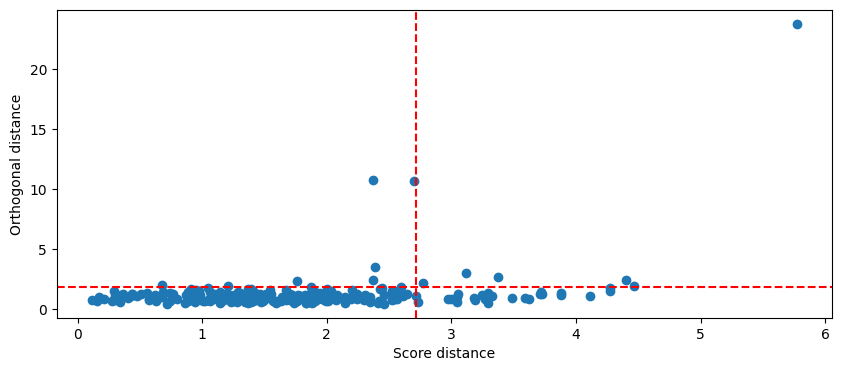

In [20]:
score_distances, orthogonal_distances, score_cutoff, od_cutoff = pca.plot_outlier_map(scaled_data, return_distances=True)

We can inspect the bad leverage points:

In [21]:
data.data.loc[
    clean_data2.loc[(score_distances > score_cutoff) & (orthogonal_distances > od_cutoff)].index, 
    ['Maker', 'Model'] + list(set(clean_data2.columns).intersection(set(data.data.columns)))
]

,Maker,Model,Displacement,TopSpeed,Torque,Weight,Price,Length,Width,Acceleration,Height,BHP,MPG
41,BMW,i3,647.0,93.0,184.0,1315.0,33830.0,3999.0,1775.0,7.9,1578.0,170.0,470.0
49,Bugatti,Veyron,7993.0,252.0,922.0,1990.0,1139985.0,4462.0,1998.0,2.5,1204.0,987.0,10.0
124,Jeep,Wrangler,2777.0,107.0,339.0,2075.0,25995.0,4223.0,1873.0,12.9,1840.0,197.0,34.0
135,Land Rover,Defender,2198.0,90.0,265.0,2120.0,28195.0,4785.0,1790.0,14.7,1790.0,122.0,25.0
164,Mercedes-Benz,G-Class,2987.0,108.0,398.0,2500.0,82945.0,4662.0,1760.0,9.1,1951.0,211.0,25.0
196,Pagani,Huayra,5980.0,230.0,811.0,1350.0,990000.0,4605.0,2036.0,3.3,1169.0,730.0,23.0


# Outlier detection

We can also detect cellwise outliers with the DDC estimator. Here we can use the data with NAs, as DDC can handle missing values.

In [22]:
ddc = DDCEstimator().fit(clean_data.drop(columns=['Price']))

<Axes: >

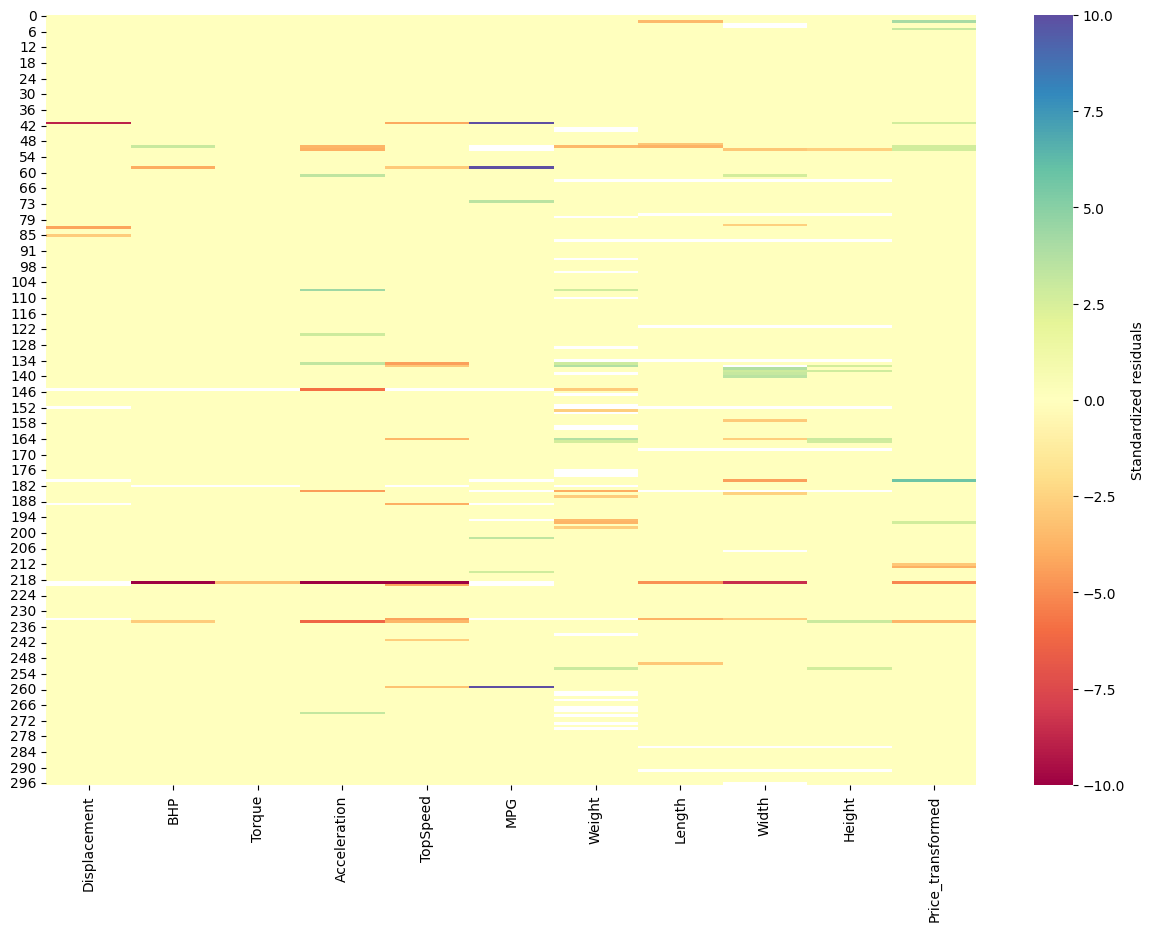

In [23]:
ddc.cellmap(clean_data.drop(columns=['Price']), figsize=(15, 10), only_color_outliers=True)

total flagged cells:

In [24]:
ddc.cellwise_outliers_.sum()

88

DDC also predicts rowwise outliers:

In [25]:
clean_data.loc[ddc.predict(clean_data.drop(columns=['Price']), rowwise=True)]

,Price,Displacement,BHP,Torque,Acceleration,TopSpeed,MPG,Weight,Length,Width,Height,Price_transformed
50,44995.0,0.219169,0.701029,-0.220938,3.1,0.921638,NaN,575.0,3300.0,1685.0,1140.0,0.668256
51,22995.0,-0.569636,-0.524540,-1.071051,5.9,-0.748566,NaN,550.0,3380.0,1575.0,1115.0,-0.247651
61,30245.0,0.613284,0.109823,0.297162,12.8,-0.590064,35.0,2305.0,5218.0,1998.0,1818.0,0.157953
124,25995.0,0.613284,0.276559,0.782252,12.9,-1.033160,34.0,2075.0,4223.0,1873.0,1840.0,-0.060330
135,28195.0,0.161107,-0.571367,0.297162,14.7,-2.246128,25.0,2120.0,4785.0,1790.0,1790.0,0.058518
145,36200.0,NaN,NaN,NaN,0.0,NaN,NaN,876.0,3785.0,1850.0,1117.0,0.399504
180,29045.0,NaN,-1.988366,-0.920764,15.9,-2.161801,NaN,1110.0,3475.0,1475.0,1610.0,0.100958
184,30000.0,-0.075638,-0.775908,-1.348513,4.5,-0.344059,NaN,490.0,NaN,NaN,NaN,0.146581
219,6950.0,NaN,-6.267469,-2.504821,0.0,-8.518526,NaN,450.0,2337.0,1237.0,1461.0,-2.690158
234,17995.0,-0.042303,-0.128325,0.297162,0.0,-1.154841,38.0,2059.0,5125.0,1915.0,1845.0,-0.652657


Finally, DDC can impute missing data:

In [26]:
ddc.impute(clean_data.drop(columns=['Price'])).loc[ddc.predict(clean_data.drop(columns=['Price']), rowwise=True), :].style.format('{:.2f}')

,Displacement,BHP,Torque,Acceleration,TopSpeed,MPG,Weight,Length,Width,Height,Price_transformed
50,0.22,-0.04,-0.22,8.61,0.92,41.82,1364.54,4331.18,1685.00,1140.00,-0.26
51,-0.57,-0.52,-1.07,11.65,-0.75,55.07,550.00,3380.00,1722.44,1482.87,-1.19
61,0.61,0.11,0.30,7.88,-0.59,35.00,2305.00,5218.00,1869.97,1818.00,0.16
124,0.61,0.28,0.78,8.73,-1.03,34.00,2075.00,4223.00,1873.00,1840.00,-0.06
135,0.16,-0.57,0.30,9.85,-0.23,25.00,1483.18,4785.00,1790.00,1790.00,0.06
145,0.21,0.49,0.12,8.79,0.87,36.24,1515.46,3785.00,1850.00,1117.00,0.40
180,-1.54,-1.99,-0.92,15.90,-2.16,65.02,1110.00,3475.00,1693.47,1610.00,-1.91
184,-0.08,-0.78,-1.35,11.16,-0.34,50.55,1391.73,4163.08,1757.11,1447.99,0.15
219,-1.47,-1.12,-1.12,15.50,-0.61,58.45,450.00,3667.15,1654.07,1461.00,-0.88
234,-0.04,0.55,0.30,9.32,0.50,38.00,2059.00,5125.00,1915.00,1428.55,0.63


# Regression

We can use robust regression to predict the (transformed) price using the remaining variables. For regression, we again have to drop all missings.

In [28]:
X = clean_data2.drop(columns=['Price', 'Price_transformed'])
y = clean_data2['Price_transformed']

As an example, we use the MM-estimator of regression:

In [29]:
estimator = MMEstimator().fit(X, y)

We can now get a diagnostic plot and ask for the underlying data

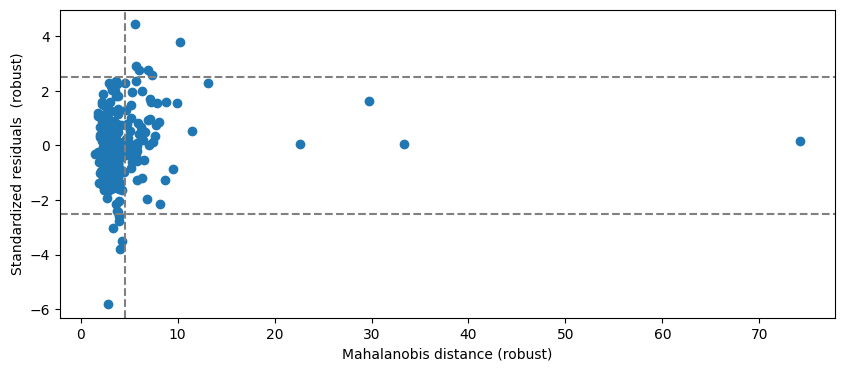

In [30]:
resid, std_resid, distances, vt, ht = estimator.diagnostic_plot(X, y.to_numpy(), return_data=True)

Now we can get an overview of the bad leverage points:

In [31]:
bad_leverage_idx = (np.abs(std_resid) > vt) & (distances > ht)
data.data.loc[
    clean_data2[bad_leverage_idx].index, ['Maker', 'Model', 'Price']
].assign(predicted_price=price_transformer.inverse_transform(estimator.predict(X.loc[bad_leverage_idx])).round())

,Maker,Model,Price,predicted_price
2,Aston Martin,Cygnet,30995.0,15326.0
5,Aston Martin,V12 Zagato,396000.0,117938.0
164,Mercedes-Benz,G-Class,82945.0,34576.0
222,Rolls-Royce,Phantom,352720.0,116166.0
223,Rolls-Royce,Phantom Coupe,333130.0,111003.0
253,Toyota,Prius,24045.0,16272.0
